In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler

from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [2]:
data = pd.read_csv("project.csv")

In [3]:
print(data.shape)
data.head()

(594643, 10)


,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


In [11]:
grouped_data = data.groupby('customer')['amount'].sum().reset_index()
print(grouped_data.shape)
grouped_data.head()


(4112, 2)


,customer,amount
0,'C1000148617',4597.04
1,'C100045114',9846.65
2,'C1000699316',3586.56
3,'C1001065306',6142.64
4,'C1002658784',4487.18


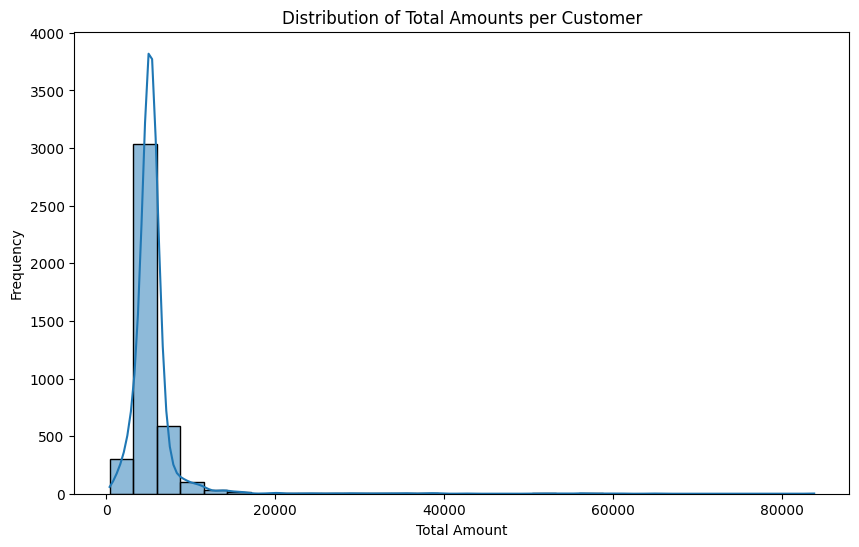

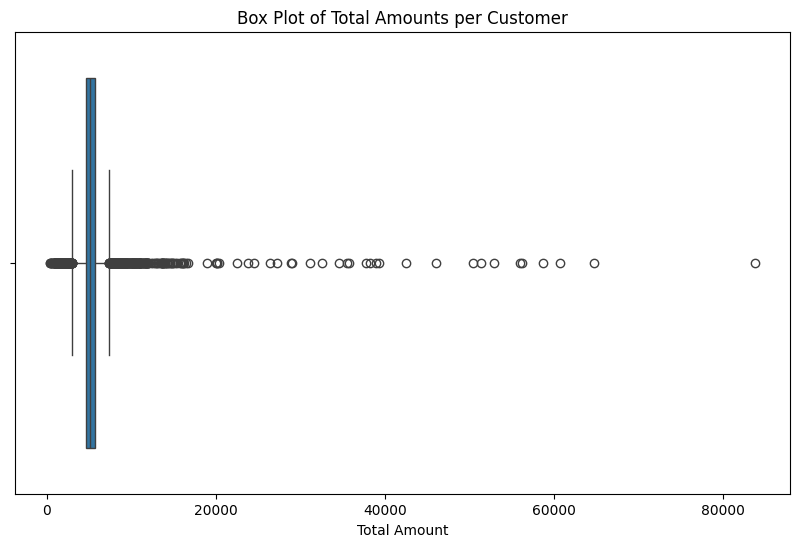

In [960]:
# Plotting the distribution of total amounts per customer
plt.figure(figsize=(10, 6))
sns.histplot(grouped_data['amount'], bins=30, kde=True)
plt.title('Distribution of Total Amounts per Customer')
plt.xlabel('Total Amount')
plt.ylabel('Frequency')
plt.show()

# Checking for outliers using a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x=grouped_data['amount'])
plt.title('Box Plot of Total Amounts per Customer')
plt.xlabel('Total Amount')
plt.show()

In [910]:
# Using the specified quantiles to define the income categories
quantiles = grouped_data["amount"].quantile([0.35, 0.6, 0.85])

quantiles.head()

# Assigning income categories based on these quantiles
def assign_income_category(amount):
    if amount <= quantiles[0.35]:
        return 'low'
    elif amount <= quantiles[0.6]:
        return 'low medium'
    elif amount <= quantiles[0.85]:
        return 'medium'
    else:
        return 'high'

grouped_data['income_category'] = grouped_data["amount"].apply(assign_income_category)
grouped_data.head()

,customer,amount,income_category,generated_income,log_amount,log_generated_income
0,'C1000148617',4597.04,low,5142.857732,8.433385,8.545559
1,'C100045114',9846.65,high,11103.727300,9.194988,9.315126
2,'C1000699316',3586.56,low,3757.888633,8.185228,8.231879
3,'C1001065306',6142.64,high,21388.535146,8.723173,9.970657
4,'C1002658784',4487.18,low,7028.930130,8.409203,8.857932


In [911]:
# Calculating the mean and standard deviation for each income category
income_stats = grouped_data.groupby('income_category')['amount'].agg(['mean', 'std'])

income_stats

,mean,std
income_category,,
high,9511.643241,7948.010245
low,3876.165733,965.969178
low medium,5110.388794,140.818760
medium,5672.312918,215.250280


In [912]:
shuffled_data = grouped_data.sample(frac=1).reset_index(drop=True)

# Calculate the size of each segment
segment_size = len(shuffled_data) // 10

# Splitting the DataFrame
first_segment_random = shuffled_data.iloc[:segment_size].copy()



In [962]:
first_segment_random.to_csv("first_random.csv")

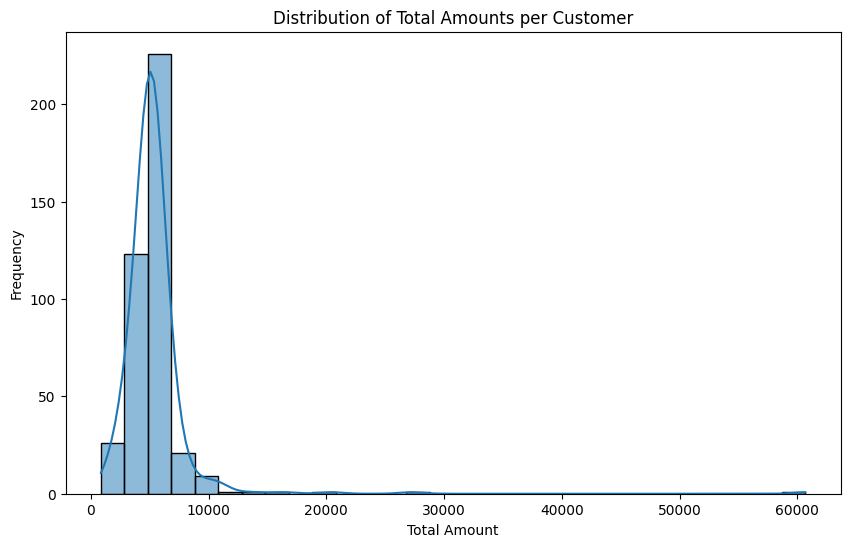

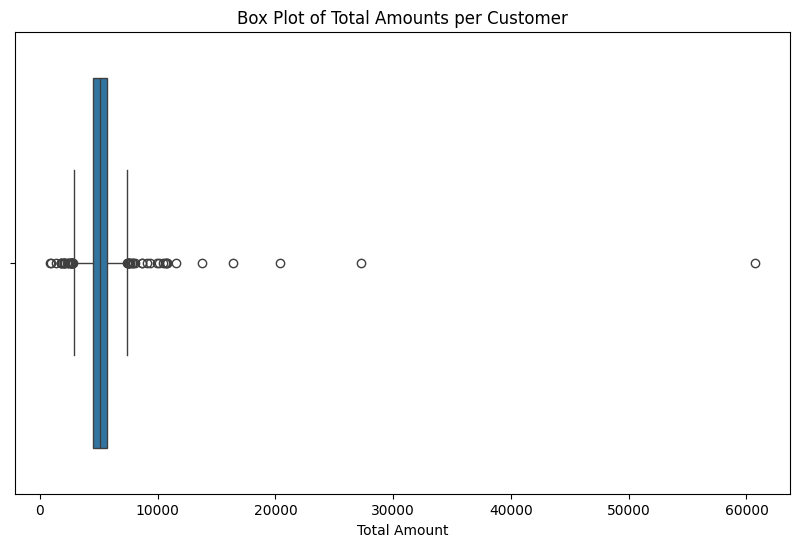

In [961]:
# Plotting the distribution of total amounts per customer
plt.figure(figsize=(10, 6))
sns.histplot(first_segment_random['amount'], bins=30, kde=True)
plt.title('Distribution of Total Amounts per Customer')
plt.xlabel('Total Amount')
plt.ylabel('Frequency')
plt.show()

# Checking for outliers using a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x=first_segment_random['amount'])
plt.title('Box Plot of Total Amounts per Customer')
plt.xlabel('Total Amount')
plt.show()

In [947]:
# Define a function to generate right-skewed normal distribution values
# Ensuring generated values are not less than the mean
def generate_right_skewed_normal(mean, std, size=1):
    values = []
    while len(values) < size:
        value = np.random.normal(
            mean * np.random.normal(0.9, 0.15) * np.random.uniform(0.85, 1), 
            std * np.random.normal(0.9, 0.15) * np.random.uniform(0.85, 1.3),  
        ) * np.random.normal(1, 0.15)
        if value >= mean:  # Accept only values greater than or equal to the mean
            values.append(value)
    return values[0]

# Applying this function to generate income values for each customer
# based on their income category
first_segment_random['generated_income'] = first_segment_random.apply(
    lambda row: generate_right_skewed_normal(income_stats.loc[row['income_category'], 'mean'],
                                             income_stats.loc[row['income_category'], 'std']),
    axis=1
)

# Displaying the first few rows of the updated dataframe
first_segment_random.head()
first_segment_random.to_csv("income.csv")

In [948]:
first_segment_random['log_amount'] = np.log(first_segment_random['amount'] + 1)  # Adding 1 to avoid log(0)
first_segment_random['log_generated_income'] = np.log(first_segment_random['generated_income'] + 1)

In [949]:
features = first_segment_random[['log_amount', 'log_generated_income']]

In [950]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [951]:
gmm = GaussianMixture(n_components=4)
gmm.fit(scaled_features)

GaussianMixture(n_components=4)

In [952]:
labels = gmm.predict(scaled_features)

In [953]:
silhouette = silhouette_score(scaled_features, labels)
silhouette

0.4869357594730495

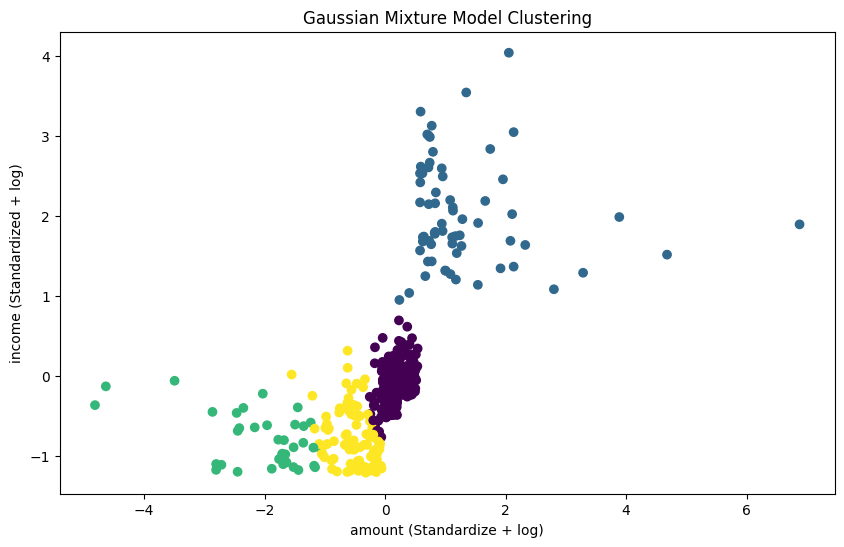

In [954]:
# Plotting the clusters
plt.figure(figsize=(10, 6))
plt.scatter(scaled_features[:, 0], scaled_features[:, 1], c=labels, marker='o')
plt.title('Gaussian Mixture Model Clustering')
plt.xlabel('amount (Standardize + log)')
plt.ylabel('income (Standardized + log)')
plt.show()

In [955]:
first_segment_random["predictions"] = labels

In [956]:
first_segment_random.head(15)

,customer,amount,income_category,generated_income,log_amount,log_generated_income,predictions
0,'C359363895',6426.88,high,11169.164938,8.768400,9.321002,1
1,'C2054233026',5963.10,medium,6496.296134,8.693513,8.779141,0
2,'C1949469724',4004.03,low,5282.708782,8.295306,8.572384,3
3,'C1809945143',5072.30,low medium,6946.033288,8.531747,8.846070,0
4,'C1032319289',7161.44,high,10659.833540,8.876606,9.274332,1
5,'C416536713',5414.92,medium,6706.742128,8.597098,8.811018,0
6,'C1293579037',5988.59,medium,6166.373583,8.697778,8.727028,0
7,'C1196357413',4284.77,low,4044.435834,8.363056,8.305345,3
8,'C1158752013',3959.23,low,6561.586050,8.284057,8.789140,3
9,'C1807970113',4894.55,low medium,6183.308708,8.496082,8.729771,0


In [957]:
dbi = davies_bouldin_score(scaled_features, labels)
dbi

0.7105955250267737

In [958]:
silhouette_avg = silhouette_score(scaled_features, labels)
silhouette_avg

0.4869357594730495

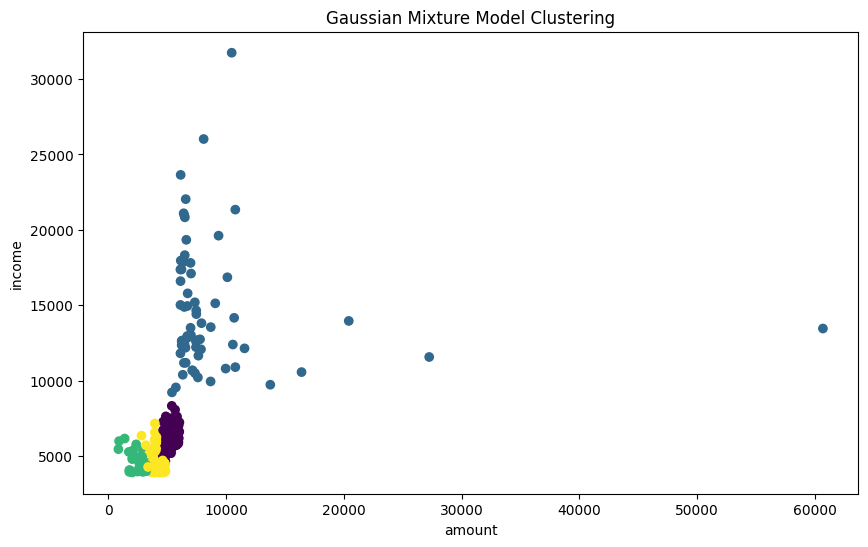

In [959]:
# Plotting the clusters
plt.figure(figsize=(10, 6))
plt.scatter(first_segment_random["amount"], first_segment_random["generated_income"], c=labels, marker='o')
plt.title('Gaussian Mixture Model Clustering')
plt.xlabel('amount')
plt.ylabel('income')
plt.show()

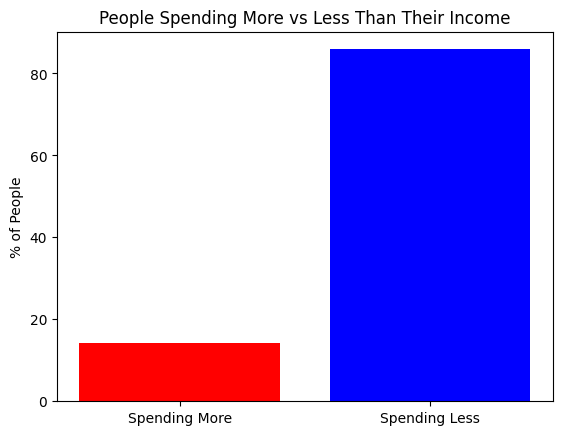

In [967]:
# Подсчет количества людей, тратящих больше и меньше своего дохода
spending_more = (first_segment_random['amount'] > first_segment_random['generated_income']).sum() / len(first_segment_random) * 100
spending_less = (first_segment_random['amount'] < first_segment_random['generated_income']).sum() / len(first_segment_random) * 100

# Построение гистограммы
plt.bar(['Spending More', 'Spending Less'], [spending_more, spending_less], color=["red", "blue"])
plt.ylabel('% of People')
plt.title('People Spending More vs Less Than Their Income')
plt.show()
